<a href="https://colab.research.google.com/github/vinisunday/Demanda_de_bicicletas/blob/main/02_comparative_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Adicionando as bibliotecas

In [1]:
import pandas as pd
import numpy as np
from scipy import stats
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.compose import ColumnTransformer
import matplotlib.pyplot as plt
import seaborn as sns

# Criação de dataframes e backup

In [2]:
df = pd.read_csv('data.csv')


In [3]:
df1 = pd.read_csv('data.csv')

# Análise pré-liminar do df

In [4]:
df.shape

(17379, 17)

In [5]:
df.isnull().sum()

,0
instant,0
dteday,0
season,868
yr,0
mnth,868
hr,868
holiday,0
weekday,868
workingday,0
weathersit,868


In [6]:
df.shape

(17379, 17)

In [7]:
df.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1.0,0,1.0,0.0,0,6.0,0,1.0,0.240000,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1.0,0,1.0,1.0,0,6.0,0,1.0,0.220000,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1.0,0,1.0,2.0,0,6.0,0,1.0,0.220000,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1.0,0,1.0,3.0,0,6.0,0,1.0,1.216284,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1.0,0,1.0,4.0,0,6.0,0,NaN,0.240000,NaN,0.75,0.0,0,1,1


In [8]:
df['dteday'] = pd.to_datetime(df['dteday'])
df.loc[df['mnth'].isna(), 'mnth'] = df.loc[df['mnth'].isna(), 'dteday'].dt.month  ##Transformando o dteday de str pra datetime

In [9]:

mes_para_estacao_num = {
    1: 4,  # Inverno
    2: 4,  # Inverno
    3: 1,  # Primavera
    4: 1,  # Primavera
    5: 1,  # Primavera
    6: 2,  # Verão
    7: 2,  # Verão
    8: 2,  # Verão
    9: 3,  # Outono
    10: 3, # Outono
    11: 3, # Outono
    12: 4  # Inverno
}

df['season'] = df['season'].fillna(df['mnth'].map(mes_para_estacao_num))


print(f"Valores nulos em 'season': {df['season'].isna().sum()}")

##criação de variáveis das estações e instalação no df

Valores nulos em 'season': 0


In [10]:
df.isnull().sum()

,0
instant,0
dteday,0
season,0
yr,0
mnth,0
hr,868
holiday,0
weekday,868
workingday,0
weathersit,868


In [11]:
df['temp'] = df['temp'].fillna(df['temp'].mean())
df['atemp'] = df['atemp'].fillna(df['atemp'].mean())
df['hum'] = df['hum'].fillna(df['hum'].mean())
df['windspeed'] = df['windspeed'].fillna(df['windspeed'].mean())
df['hr'] = df['hr'].fillna(df['hr'].mean()) ##preenchendo com a média os valores faltantes

In [12]:
df.isnull().sum()

,0
instant,0
dteday,0
season,0
yr,0
mnth,0
hr,0
holiday,0
weekday,868
workingday,0
weathersit,868


In [13]:
clima = {1: 'Limpo', 2: 'Nublado', 3: 'Chuva Leve', 4: 'Chuva Forte'}
df['weathersit'] = df['weathersit'].map(clima)
df = pd.get_dummies(df, columns=['weathersit'], drop_first=True) ##criando as dummies

In [14]:
df['fim_de_semana'] = df['weekday'].apply(lambda x: 1 if x >= 5 else 0) ##criando a variável fim de semana

In [15]:
df = pd.get_dummies(df, columns=['weekday'], prefix='dia')

In [16]:
demanda_media_hora = df.groupby('hr')['cnt'].mean().to_dict()
df['demanda_media_hora'] = df['hr'].map(demanda_media_hora) ##criando uma variável pra relacionar a demanda com o horario

In [17]:
df['hora_cat'] = pd.cut(df['hr'], bins=[0, 6, 12, 18, 24], labels=['Madrugada', 'Manhã', 'Tarde', 'Noite'])
df = pd.get_dummies(df, columns=['hora_cat']) ##criando dummies para o horario

In [18]:
scaler = StandardScaler()
df[['temp', 'atemp', 'hum', 'windspeed']] = scaler.fit_transform(df[['temp', 'atemp', 'hum', 'windspeed']]) ##normalizando as variáveis

# Analisando outliers

In [19]:
Q1 = df['cnt'].quantile(0.25)
Q3 = df['cnt'].quantile(0.75)
IQR = Q3 - Q1

print(f"Q1: {Q1}, Q3: {Q3}, IQR: {IQR}") ##utilizando IQR

Q1: 40.0, Q3: 281.0, IQR: 241.0


In [20]:
limite_inferior = Q1 - 1.5 * IQR
limite_superior = Q3 + 1.5 * IQR

print(f"Limite Inferior: {limite_inferior}, Limite Superior: {limite_superior}")

Limite Inferior: -321.5, Limite Superior: 642.5


In [21]:

outliers = df[(df['cnt'] < limite_inferior) | (df['cnt'] > limite_superior)]

print(f"Total de outliers: {len(outliers)}")
print(outliers[['dteday', 'cnt']])  ##Verificando quais linhas tem outliers

Total de outliers: 505
          dteday  cnt
5536  2011-08-23  651
10358 2012-03-12  644
10359 2012-03-12  712
10382 2012-03-13  676
10383 2012-03-13  734
...          ...  ...
16885 2012-12-11  724
16909 2012-12-12  688
16933 2012-12-13  679
17053 2012-12-18  662
17077 2012-12-19  678

[505 rows x 2 columns]


In [22]:
df.drop(outliers.index, inplace=True) ##testando para ver se, ao limpar, as métricas melhoram

# Treinando o modelo com regressão linear

In [25]:
X = df.drop(['cnt', 'casual', 'registered', 'dteday', 'instant'], axis=1)

In [26]:
y = df['cnt']

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [28]:
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [29]:
y_pred = model.predict(X_test)

In [30]:
mae = mean_absolute_error(y_test, y_pred)
rmse0 = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(rmse0)
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2:.2f}")

MAE: 70.91
RMSE: 95.61
R²: 0.61


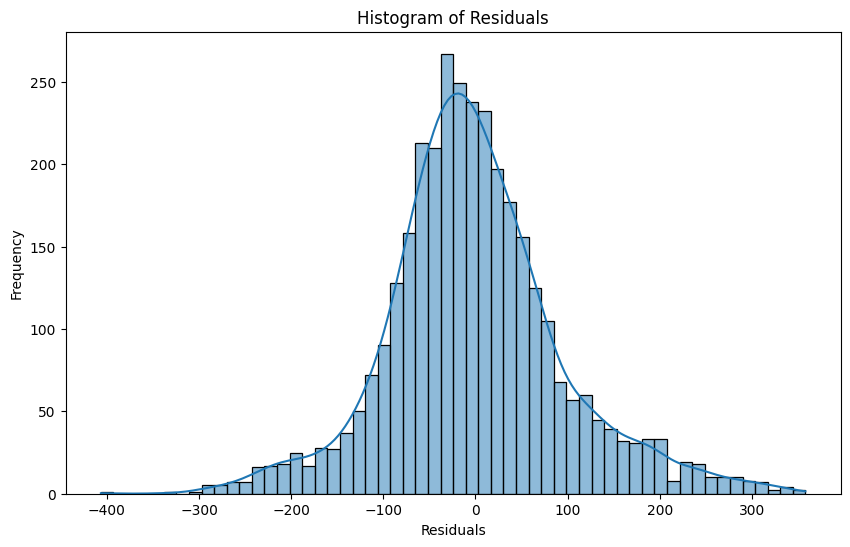

In [31]:
residuals = y_test - y_pred
plt.figure(figsize=(10, 6))
sns.histplot(residuals, kde=True)
plt.xlabel("Residuos")
plt.ylabel("Frequencia")
plt.title("Histograma dos residuos")
plt.show() ##histograma dos resíduos

In [32]:
df1.dropna(inplace=True)

# Treinando o modelo com random forest

In [33]:

df1['season'] = df1['season'].map({1: 'Primavera', 2: 'Verão', 3: 'Outono', 4: 'Inverno'})
df1['weathersit'] = df1['weathersit'].map({1: 'Limpo', 2: 'Nublado', 3: 'Chuva Leve', 4: 'Chuva Forte'})

X0 = df1.drop(['cnt', 'casual', 'registered', 'dteday', 'instant'], axis=1)
y0= df1['cnt']

numeric_features = ['temp', 'atemp', 'hum', 'windspeed']
categorical_features = ['season', 'weathersit', 'weekday']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(drop='first'), categorical_features)
    ])


X_treino, X_teste, y_treino, y_teste = train_test_split(X0, y0, test_size=0.2, random_state=42)


X_train_processed = preprocessor.fit_transform(X_treino) ##treino
X_test_processed = preprocessor.transform(X_teste) ##pre processamento

In [34]:

rf_model = RandomForestRegressor(
    n_estimators=100,
    max_depth=10,
    random_state=42
)
rf_model.fit(X_train_processed, y_treino)


y_pred_rf = rf_model.predict(X_test_processed) ## resultados do random forest

In [35]:

mae_rf = mean_absolute_error(y_teste, y_pred_rf)
rmse_rf0 = mean_squared_error(y_teste, y_pred_rf)
rmse_ref = np.sqrt(rmse_rf0)
r2_rf = r2_score(y_teste, y_pred_rf)

print(f"MAE (Random Forest): {mae_rf:.2f}")
print(f"RMSE (Random Forest): {rmse_ref:.2f}")
print(f"R² (Random Forest): {r2_rf:.2f}") ## métricas para o modelo de random forest

MAE (Random Forest): 106.10
RMSE (Random Forest): 143.68
R² (Random Forest): 0.37


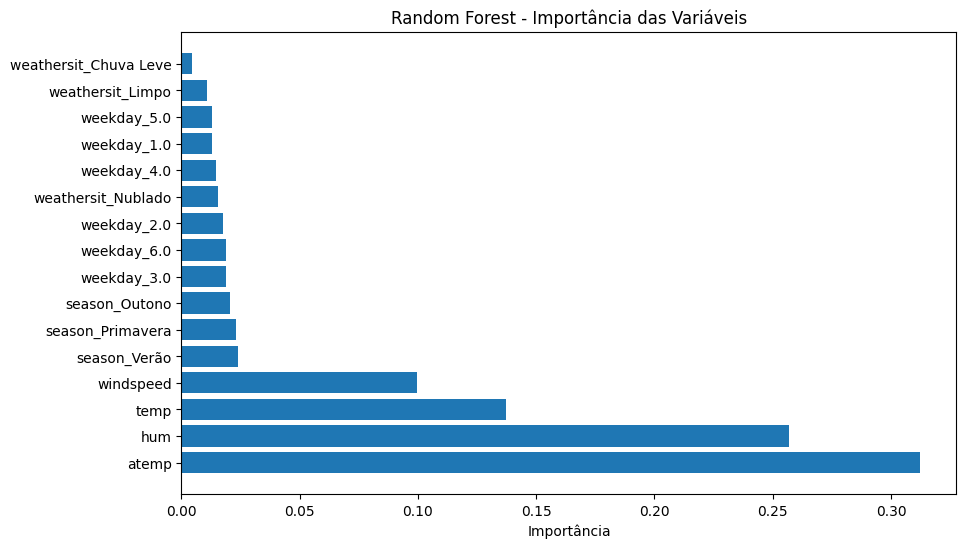

In [38]:

feature_names = numeric_features + list(preprocessor.named_transformers_['cat'].get_feature_names_out())


importances = rf_model.feature_importances_
feature_importance = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_importance = feature_importance.sort_values('Importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(feature_importance['Feature'], feature_importance['Importance'])
plt.xlabel('Importância')
plt.title('Random Forest - Importância das Variáveis')
plt.show()
##verificando a importância das variáveis